In [1]:
import torch
torch.__version__

'2.5.0+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import numpy as np
import pandas as pd
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision.models import mobilenet_v3_large
import random
import gc
import math

C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\MoKha\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
# Set seed for reproducibility
SEED = 123
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Data

In [5]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by 10 degrees
    transforms.RandomResizedCrop(
        size=IMG_SIZE,  # Output size
        scale=(0.8, 1.0)  # Range of the random crop size relative to the input size
    ),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
test transforms: Compose(
    Grayscale(num_output_channels=3)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [7]:
data = pd.read_csv('D://Kuliah//UPI//SEMESTER 8//dataset skripsi//fer2013v2_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33303 entries, 0 to 33302
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33303 non-null  object
 1   emotion  33303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.5+ KB


In [8]:
# pisahkan data train (80%), validation (10%), test (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26974
Validation set size: 2998
Test set size: 3331


In [9]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

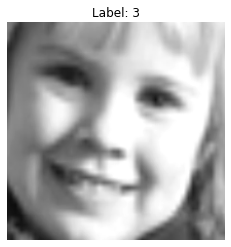

In [10]:
# Define the mean and std used for normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Denormalize function
def denormalize(tensor, mean, std):
    # Clone the tensor to avoid modifying the original
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization: (t * s) + m
    return tensor

# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Denormalize the image
image = denormalize(image, mean, std)

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Clip the values to the valid range [0, 1]
image = image.clip(0, 1)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [11]:
image, label = train_dataset[0]
image.shape

torch.Size([3, 224, 224])

## Build Vision Transformer (ViT) Model

In [12]:
from torch import nn

In [13]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [14]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [15]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [16]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0., # Dropout for attention projection
                 mlp_dropout:float=0., # Dropout for dense/MLP layers 
                 embedding_dropout:float=0., # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()
         
        assert img_size % 32 == 0, f"Image size must be divisible by 32, image size: {img_size}"
        
        self.backbone = mobilenet_v3_large(pretrained=True).features
        
        self.projection = nn.Sequential(
            nn.Conv2d(960, embedding_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embedding_dim),
            nn.GELU(),
            nn.Conv2d(embedding_dim, embedding_dim, kernel_size=1)
        )
        
        self.num_patches = (img_size // 32) ** 2  # MobileNet reduces spatial size by 32x
        self.position_embedding = self._create_sine_position_embeddings(embedding_dim)
                 
        self.cnn_scale = nn.Parameter(torch.ones(1))
        
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    def _create_sine_position_embeddings(self, dim):
        """Create sine-cosine position embeddings"""
        position = torch.arange(self.num_patches + 1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(1, self.num_patches + 1, dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pe, requires_grad=False)  # Often kept fixed
    
    def forward(self, pixel_values, labels=None):
        
        batch_size = pixel_values.shape[0]

        # Extract features using MobileNet
        x = self.backbone(pixel_values)
        x = self.projection(x)

        # Flatten the feature maps into a sequence of tokens
        x = x.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, embedding_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) * self.cnn_scale

        x = torch.cat((class_token, x), dim=1)  # Shape: (batch_size, num_patches + 1, embedding_dim)

        x = x + self.position_embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        return logits

## Model Training

In [17]:
class BestModelSaver:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        self.best_accuracy = -float('inf')
        os.makedirs(self.save_path, exist_ok=True)

    def save(self, model, current_accuracy, epoch):
        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            model_path = os.path.join(self.save_path, f"{self.model_name}_best.pt")
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved at {model_path} with accuracy: {self.best_accuracy:.4f}")

In [18]:
class MetricsPlotter:
    def __init__(self, save_path, model_name):
        self.save_path = save_path
        self.model_name = model_name
        os.makedirs(self.save_path, exist_ok=True)

    def plot_and_save(self, train_metrics, val_metrics, metric_name, epoch):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_metrics) + 1), train_metrics, label=f"Training {metric_name}", marker='o')
        plt.plot(range(1, len(val_metrics) + 1), val_metrics, label=f"Validation {metric_name}", marker='o')
        plt.title(f"{self.model_name} {metric_name} per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.save_path, f"{self.model_name}_{metric_name.lower()}.png")
        plt.savefig(plot_path)
        plt.close()

In [19]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1

        if self.epochs_no_improve >= self.patience:
            self.early_stop = True

        return self.early_stop

In [20]:
class Validator:
    def __init__(self, model, criterion, device):
        self.model = model
        self.criterion = criterion
        self.device = device

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_targets = []
        all_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(val_loader, desc="Validation")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions for F1-score
                all_targets.extend(targets.cpu().numpy())
                all_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{val_correct / val_total:.4f}"
                })

        # Calculate validation accuracy, loss, and F1-score
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(all_targets, all_predicted, average="weighted")

        return avg_val_loss, val_accuracy, val_f1

In [21]:
dropouts = [0.1, 0.3, 0.5, 0.7]

EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# Define the CSV file paths
epoch_csv_path = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//attn_dropout_epoch_results.csv"
test_csv_path = "D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//attn_dropout_test_results.csv"

# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(epoch_csv_path):
    with open(epoch_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Attn Dropout", "Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc", "F1 Score", "Learning Rate"])
        
# Check if the epoch results CSV file exists. If not, create it and write the header.
if not os.path.exists(test_csv_path):
    with open(test_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Attn Dropout", "Test Loss", "Test Acc", "F1 Score"])

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Open the configuration CSV file in append mode
with open(epoch_csv_path, mode='a', newline='') as epoch_file, \
     open(test_csv_path, mode='a', newline='') as test_file:
    
    epoch_writer = csv.writer(epoch_file)
    test_writer = csv.writer(test_file)

    idx = 1

    for dropout in dropouts:
        print(f"Start model{idx} with configuration dropout: {dropout}")

        # Model initialization
        model = ViT(num_classes=len(class_names), 
                    in_channels=3, 
                    patch_size=32, 
                    num_heads=4, 
                    embedding_dim=256, 
                    num_transformer_layers=6,
                    attn_dropout=dropout)

        model = model.to(DEVICE)

        # Initialize BestModelSaver and MetricsPlotter
        model_saver = BestModelSaver(save_path="D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2", model_name=f"model{idx}_dropout")
        metrics_plotter = MetricsPlotter(save_path="D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2", model_name=f"model{idx}_dropout")

        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        # Define the learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        early_stopping = EarlyStopping(patience=15, min_delta=0)

        # Initialize Validator
        validator = Validator(model=model, criterion=criterion, device=DEVICE)

        # Initialize lists to store training and validation metrics
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            # Training
            pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{train_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{correct / total:.4f}"
                })

            # Calculate training accuracy and loss
            train_accuracy = correct / total
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            train_accuracies.append(train_accuracy)

            # Print training summary
            print(f"Epoch {epoch + 1}/{EPOCHS}: "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}")

            # ===== VALIDATION =======
            avg_val_loss, val_accuracy, val_f1 = validator.validate(val_loader)
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)

            # Print validation summary
            print(f"Epoch {epoch + 1}/{EPOCHS}: "
                  f"Val Loss: {avg_val_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, "
                  f"Val F1: {val_f1:.4f}")

            # Step the learning rate scheduler based on validation loss
            scheduler.step(avg_val_loss)

            # Print the current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current Learning Rate: {current_lr}")

            # Save the best model based on validation accuracy
            model_saver.save(model, val_accuracy, epoch)

            # Save loss and accuracy plots
            metrics_plotter.plot_and_save(train_losses, val_losses, "Loss", epoch)
            metrics_plotter.plot_and_save(train_accuracies, val_accuracies, "Accuracy", epoch)

            # Save epoch results to CSV
            epoch_writer.writerow([
                dropout,  # Config
                epoch + 1,  # Epoch
                avg_train_loss,  # Train Loss
                train_accuracy,  # Train Acc
                avg_val_loss,  # Val Loss
                val_accuracy,  # Val Acc
                val_f1,  # F1 Score
                current_lr  # Learning Rate
            ])

            # Early stopping check
            if early_stopping(avg_val_loss):
                print(f"Early stopping triggered at epoch {epoch + 1}!")
                break

        # Clear GPU memory after each configuration
        del model, optimizer, scheduler
        torch.cuda.empty_cache()
        gc.collect()

        # ======= TESTING ========
        best_model = ViT(num_classes=len(class_names), 
                            in_channels=3, 
                            patch_size=32, 
                            num_heads=4, 
                            embedding_dim=256, 
                            num_transformer_layers=6,
                            embedding_dropout=dropout,
                            mlp_dropout=dropout)
        best_model.to(DEVICE)
        best_model.load_state_dict(torch.load(f"D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2//model{idx}_dropout_best.pt", weights_only=False))

        best_model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        all_test_targets = []
        all_test_predicted = []

        with torch.no_grad():  # Disable gradient computation
            pbar = tqdm(test_loader, desc="Testing")
            for batch_idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # Forward pass
                outputs = best_model(inputs)
                loss = criterion(outputs, targets)

                # Update statistics
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

                # Collect all targets and predictions
                all_test_targets.extend(targets.cpu().numpy())
                all_test_predicted.extend(predicted.cpu().numpy())

                # Update progress bar
                pbar.set_postfix({
                    "Loss": f"{test_loss / (batch_idx + 1):.4f}",
                    "Acc": f"{test_correct / test_total:.4f}"
                })

        # Calculate test accuracy, loss, and F1-score
        test_accuracy = test_correct / test_total
        avg_test_loss = test_loss / len(test_loader)
        test_f1 = f1_score(all_test_targets, all_test_predicted, average="weighted")

        # Print test summary
        print(f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Acc: {test_accuracy:.4f}, "
              f"Test F1: {test_f1:.4f}")

        # Clear GPU memory after each configuration
        del best_model
        torch.cuda.empty_cache()
        gc.collect()

        # Save the configuration to the CSV file
        test_writer.writerow([dropout, avg_test_loss, test_accuracy, test_f1])

        idx+=1

Start model1 with configuration dropout: 0.1


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [02:28<00:00,  2.83it/s, Loss=1.3848, Acc=0.4607]


Epoch 1/1000: Train Loss: 1.3848, Train Acc: 0.4607


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.75it/s, Loss=1.2101, Acc=0.5360]


Epoch 1/1000: Val Loss: 1.2101, Val Acc: 0.5360, Val F1: 0.5232
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.5360


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [02:30<00:00,  2.80it/s, Loss=1.1369, Acc=0.5704]


Epoch 2/1000: Train Loss: 1.1369, Train Acc: 0.5704


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.50it/s, Loss=1.0794, Acc=0.5937]


Epoch 2/1000: Val Loss: 1.0794, Val Acc: 0.5937, Val F1: 0.5756
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.5937


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [02:30<00:00,  2.81it/s, Loss=1.0425, Acc=0.6027]


Epoch 3/1000: Train Loss: 1.0425, Train Acc: 0.6027


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.33it/s, Loss=1.0636, Acc=0.5974]


Epoch 3/1000: Val Loss: 1.0636, Val Acc: 0.5974, Val F1: 0.5794
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.5974


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [02:34<00:00,  2.73it/s, Loss=0.9738, Acc=0.6275]


Epoch 4/1000: Train Loss: 0.9738, Train Acc: 0.6275


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.02it/s, Loss=1.0071, Acc=0.6294]


Epoch 4/1000: Val Loss: 1.0071, Val Acc: 0.6294, Val F1: 0.6141
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6294


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [02:34<00:00,  2.72it/s, Loss=0.9178, Acc=0.6548]


Epoch 5/1000: Train Loss: 0.9178, Train Acc: 0.6548


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.79it/s, Loss=0.9775, Acc=0.6381]


Epoch 5/1000: Val Loss: 0.9775, Val Acc: 0.6381, Val F1: 0.6340
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6381


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [02:35<00:00,  2.72it/s, Loss=0.8709, Acc=0.6716]


Epoch 6/1000: Train Loss: 0.8709, Train Acc: 0.6716


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.71it/s, Loss=0.9518, Acc=0.6421]


Epoch 6/1000: Val Loss: 0.9518, Val Acc: 0.6421, Val F1: 0.6368
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6421


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [02:39<00:00,  2.64it/s, Loss=0.8236, Acc=0.6890]


Epoch 7/1000: Train Loss: 0.8236, Train Acc: 0.6890


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.81it/s, Loss=0.9585, Acc=0.6474]


Epoch 7/1000: Val Loss: 0.9585, Val Acc: 0.6474, Val F1: 0.6391
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6474


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [02:45<00:00,  2.54it/s, Loss=0.7779, Acc=0.7102]


Epoch 8/1000: Train Loss: 0.7779, Train Acc: 0.7102


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.88it/s, Loss=0.9630, Acc=0.6544]


Epoch 8/1000: Val Loss: 0.9630, Val Acc: 0.6544, Val F1: 0.6488
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6544


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=0.7320, Acc=0.7263]


Epoch 9/1000: Train Loss: 0.7320, Train Acc: 0.7263


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.55it/s, Loss=0.9379, Acc=0.6661]


Epoch 9/1000: Val Loss: 0.9379, Val Acc: 0.6661, Val F1: 0.6636
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model1_dropout_best.pt with accuracy: 0.6661


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [02:48<00:00,  2.50it/s, Loss=0.6883, Acc=0.7445]


Epoch 10/1000: Train Loss: 0.6883, Train Acc: 0.7445


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.18it/s, Loss=0.9865, Acc=0.6458]


Epoch 10/1000: Val Loss: 0.9865, Val Acc: 0.6458, Val F1: 0.6401
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [02:48<00:00,  2.51it/s, Loss=0.6454, Acc=0.7624]


Epoch 11/1000: Train Loss: 0.6454, Train Acc: 0.7624


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.71it/s, Loss=1.0081, Acc=0.6484]


Epoch 11/1000: Val Loss: 1.0081, Val Acc: 0.6484, Val F1: 0.6412
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [02:46<00:00,  2.54it/s, Loss=0.5980, Acc=0.7781]


Epoch 12/1000: Train Loss: 0.5980, Train Acc: 0.7781


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.94it/s, Loss=1.0154, Acc=0.6374]


Epoch 12/1000: Val Loss: 1.0154, Val Acc: 0.6374, Val F1: 0.6359
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [02:44<00:00,  2.56it/s, Loss=0.5573, Acc=0.7963]


Epoch 13/1000: Train Loss: 0.5573, Train Acc: 0.7963


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.15it/s, Loss=1.0377, Acc=0.6548]


Epoch 13/1000: Val Loss: 1.0377, Val Acc: 0.6548, Val F1: 0.6450
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [02:50<00:00,  2.48it/s, Loss=0.5207, Acc=0.8117]


Epoch 14/1000: Train Loss: 0.5207, Train Acc: 0.8117


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.48it/s, Loss=1.0943, Acc=0.6571]


Epoch 14/1000: Val Loss: 1.0943, Val Acc: 0.6571, Val F1: 0.6553
Current Learning Rate: 3e-05


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [02:47<00:00,  2.53it/s, Loss=0.4902, Acc=0.8218]


Epoch 15/1000: Train Loss: 0.4902, Train Acc: 0.8218


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.85it/s, Loss=1.0577, Acc=0.6448]


Epoch 15/1000: Val Loss: 1.0577, Val Acc: 0.6448, Val F1: 0.6473
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [02:44<00:00,  2.57it/s, Loss=0.3863, Acc=0.8616]


Epoch 16/1000: Train Loss: 0.3863, Train Acc: 0.8616


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.17it/s, Loss=1.1299, Acc=0.6554]


Epoch 16/1000: Val Loss: 1.1299, Val Acc: 0.6554, Val F1: 0.6503
Current Learning Rate: 3e-06


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=0.3675, Acc=0.8682]


Epoch 17/1000: Train Loss: 0.3675, Train Acc: 0.8682


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.33it/s, Loss=1.1432, Acc=0.6494]


Epoch 17/1000: Val Loss: 1.1432, Val Acc: 0.6494, Val F1: 0.6487
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [02:46<00:00,  2.53it/s, Loss=0.3561, Acc=0.8740]


Epoch 18/1000: Train Loss: 0.3561, Train Acc: 0.8740


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.28it/s, Loss=1.1540, Acc=0.6584]


Epoch 18/1000: Val Loss: 1.1540, Val Acc: 0.6584, Val F1: 0.6562
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [02:40<00:00,  2.64it/s, Loss=0.3450, Acc=0.8786]


Epoch 19/1000: Train Loss: 0.3450, Train Acc: 0.8786


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.88it/s, Loss=1.1679, Acc=0.6568]


Epoch 19/1000: Val Loss: 1.1679, Val Acc: 0.6568, Val F1: 0.6555
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=0.3333, Acc=0.8801]


Epoch 20/1000: Train Loss: 0.3333, Train Acc: 0.8801


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=1.1761, Acc=0.6568]


Epoch 20/1000: Val Loss: 1.1761, Val Acc: 0.6568, Val F1: 0.6545
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.73it/s, Loss=0.3270, Acc=0.8836]


Epoch 21/1000: Train Loss: 0.3270, Train Acc: 0.8836


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.98it/s, Loss=1.1765, Acc=0.6538]


Epoch 21/1000: Val Loss: 1.1765, Val Acc: 0.6538, Val F1: 0.6520
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [02:58<00:00,  2.36it/s, Loss=0.3201, Acc=0.8861]


Epoch 22/1000: Train Loss: 0.3201, Train Acc: 0.8861


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s, Loss=1.1821, Acc=0.6574]


Epoch 22/1000: Val Loss: 1.1821, Val Acc: 0.6574, Val F1: 0.6558
Current Learning Rate: 3.0000000000000004e-07


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [02:53<00:00,  2.43it/s, Loss=0.3177, Acc=0.8870]


Epoch 23/1000: Train Loss: 0.3177, Train Acc: 0.8870


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.11it/s, Loss=1.1835, Acc=0.6594]


Epoch 23/1000: Val Loss: 1.1835, Val Acc: 0.6594, Val F1: 0.6574
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [02:41<00:00,  2.61it/s, Loss=0.3118, Acc=0.8888]


Epoch 24/1000: Train Loss: 0.3118, Train Acc: 0.8888


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=1.1893, Acc=0.6578]


Epoch 24/1000: Val Loss: 1.1893, Val Acc: 0.6578, Val F1: 0.6555
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 24!


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|████████████████████████████████████████████████| 53/53 [00:05<00:00,  9.73it/s, Loss=0.9053, Acc=0.6635]
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users

Test Loss: 0.9053, Test Acc: 0.6635, Test F1: 0.6605
Start model2 with configuration dropout: 0.3


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=1.3682, Acc=0.4719]


Epoch 1/1000: Train Loss: 1.3682, Train Acc: 0.4719


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.86it/s, Loss=1.2311, Acc=0.5257]


Epoch 1/1000: Val Loss: 1.2311, Val Acc: 0.5257, Val F1: 0.5109
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.5257


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.1242, Acc=0.5728]


Epoch 2/1000: Train Loss: 1.1242, Train Acc: 0.5728


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.96it/s, Loss=1.0826, Acc=0.5914]


Epoch 2/1000: Val Loss: 1.0826, Val Acc: 0.5914, Val F1: 0.5714
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.5914


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=1.0288, Acc=0.6113]


Epoch 3/1000: Train Loss: 1.0288, Train Acc: 0.6113


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.85it/s, Loss=1.0440, Acc=0.6031]


Epoch 3/1000: Val Loss: 1.0440, Val Acc: 0.6031, Val F1: 0.5939
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6031


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.9654, Acc=0.6352]


Epoch 4/1000: Train Loss: 0.9654, Train Acc: 0.6352


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=1.0334, Acc=0.6164]


Epoch 4/1000: Val Loss: 1.0334, Val Acc: 0.6164, Val F1: 0.6098
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6164


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.9057, Acc=0.6581]


Epoch 5/1000: Train Loss: 0.9057, Train Acc: 0.6581


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.95it/s, Loss=1.0133, Acc=0.6204]


Epoch 5/1000: Val Loss: 1.0133, Val Acc: 0.6204, Val F1: 0.6028
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6204


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.8595, Acc=0.6759]


Epoch 6/1000: Train Loss: 0.8595, Train Acc: 0.6759


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.03it/s, Loss=0.9740, Acc=0.6411]


Epoch 6/1000: Val Loss: 0.9740, Val Acc: 0.6411, Val F1: 0.6285
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6411


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.8126, Acc=0.6921]


Epoch 7/1000: Train Loss: 0.8126, Train Acc: 0.6921


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.94it/s, Loss=0.9491, Acc=0.6451]


Epoch 7/1000: Val Loss: 0.9491, Val Acc: 0.6451, Val F1: 0.6407
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6451


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=0.7657, Acc=0.7144]


Epoch 8/1000: Train Loss: 0.7657, Train Acc: 0.7144


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.97it/s, Loss=0.9724, Acc=0.6474]


Epoch 8/1000: Val Loss: 0.9724, Val Acc: 0.6474, Val F1: 0.6377
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6474


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.7182, Acc=0.7356]


Epoch 9/1000: Train Loss: 0.7182, Train Acc: 0.7356


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.89it/s, Loss=0.9776, Acc=0.6468]


Epoch 9/1000: Val Loss: 0.9776, Val Acc: 0.6468, Val F1: 0.6393
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.6744, Acc=0.7492]


Epoch 10/1000: Train Loss: 0.6744, Train Acc: 0.7492


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.95it/s, Loss=0.9770, Acc=0.6531]


Epoch 10/1000: Val Loss: 0.9770, Val Acc: 0.6531, Val F1: 0.6514
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6531


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.6286, Acc=0.7707]


Epoch 11/1000: Train Loss: 0.6286, Train Acc: 0.7707


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.81it/s, Loss=0.9900, Acc=0.6584]


Epoch 11/1000: Val Loss: 0.9900, Val Acc: 0.6584, Val F1: 0.6541
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6584


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.5777, Acc=0.7898]


Epoch 12/1000: Train Loss: 0.5777, Train Acc: 0.7898


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.92it/s, Loss=1.0541, Acc=0.6374]


Epoch 12/1000: Val Loss: 1.0541, Val Acc: 0.6374, Val F1: 0.6392
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.5409, Acc=0.8021]


Epoch 13/1000: Train Loss: 0.5409, Train Acc: 0.8021


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.98it/s, Loss=1.0640, Acc=0.6634]


Epoch 13/1000: Val Loss: 1.0640, Val Acc: 0.6634, Val F1: 0.6570
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model2_dropout_best.pt with accuracy: 0.6634


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.4387, Acc=0.8434]


Epoch 14/1000: Train Loss: 0.4387, Train Acc: 0.8434


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.98it/s, Loss=1.0738, Acc=0.6614]


Epoch 14/1000: Val Loss: 1.0738, Val Acc: 0.6614, Val F1: 0.6606
Current Learning Rate: 3e-06


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.79it/s, Loss=0.4144, Acc=0.8527]


Epoch 15/1000: Train Loss: 0.4144, Train Acc: 0.8527


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.89it/s, Loss=1.0976, Acc=0.6594]


Epoch 15/1000: Val Loss: 1.0976, Val Acc: 0.6594, Val F1: 0.6589
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.4016, Acc=0.8564]


Epoch 16/1000: Train Loss: 0.4016, Train Acc: 0.8564


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.05it/s, Loss=1.1148, Acc=0.6554]


Epoch 16/1000: Val Loss: 1.1148, Val Acc: 0.6554, Val F1: 0.6547
Current Learning Rate: 3e-06


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.74it/s, Loss=0.3954, Acc=0.8596]


Epoch 17/1000: Train Loss: 0.3954, Train Acc: 0.8596


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.91it/s, Loss=1.1245, Acc=0.6561]


Epoch 17/1000: Val Loss: 1.1245, Val Acc: 0.6561, Val F1: 0.6563
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.3781, Acc=0.8660]


Epoch 18/1000: Train Loss: 0.3781, Train Acc: 0.8660


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.83it/s, Loss=1.1403, Acc=0.6601]


Epoch 18/1000: Val Loss: 1.1403, Val Acc: 0.6601, Val F1: 0.6578
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.3720, Acc=0.8676]


Epoch 19/1000: Train Loss: 0.3720, Train Acc: 0.8676


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.00it/s, Loss=1.1538, Acc=0.6584]


Epoch 19/1000: Val Loss: 1.1538, Val Acc: 0.6584, Val F1: 0.6575
Current Learning Rate: 3.0000000000000004e-07


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.3691, Acc=0.8690]


Epoch 20/1000: Train Loss: 0.3691, Train Acc: 0.8690


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.96it/s, Loss=1.1497, Acc=0.6564]


Epoch 20/1000: Val Loss: 1.1497, Val Acc: 0.6564, Val F1: 0.6555
Current Learning Rate: 3.0000000000000004e-07


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.3628, Acc=0.8702]


Epoch 21/1000: Train Loss: 0.3628, Train Acc: 0.8702


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.04it/s, Loss=1.1520, Acc=0.6554]


Epoch 21/1000: Val Loss: 1.1520, Val Acc: 0.6554, Val F1: 0.6544
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.3600, Acc=0.8709]


Epoch 22/1000: Train Loss: 0.3600, Train Acc: 0.8709


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.80it/s, Loss=1.1536, Acc=0.6568]


Epoch 22/1000: Val Loss: 1.1536, Val Acc: 0.6568, Val F1: 0.6560
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 22!


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|████████████████████████████████████████████████| 53/53 [00:05<00:00, 10.17it/s, Loss=1.0321, Acc=0.6692]
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users

Test Loss: 1.0321, Test Acc: 0.6692, Test F1: 0.6604
Start model3 with configuration dropout: 0.5


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=1.3760, Acc=0.4694]


Epoch 1/1000: Train Loss: 1.3760, Train Acc: 0.4694


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.95it/s, Loss=1.2020, Acc=0.5307]


Epoch 1/1000: Val Loss: 1.2020, Val Acc: 0.5307, Val F1: 0.5119
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.5307


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=1.1392, Acc=0.5661]


Epoch 2/1000: Train Loss: 1.1392, Train Acc: 0.5661


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.98it/s, Loss=1.0840, Acc=0.5874]


Epoch 2/1000: Val Loss: 1.0840, Val Acc: 0.5874, Val F1: 0.5705
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.5874


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=1.0436, Acc=0.6030]


Epoch 3/1000: Train Loss: 1.0436, Train Acc: 0.6030


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=1.0336, Acc=0.6167]


Epoch 3/1000: Val Loss: 1.0336, Val Acc: 0.6167, Val F1: 0.5975
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6167


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.78it/s, Loss=0.9723, Acc=0.6317]


Epoch 4/1000: Train Loss: 0.9723, Train Acc: 0.6317


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.92it/s, Loss=1.0145, Acc=0.6214]


Epoch 4/1000: Val Loss: 1.0145, Val Acc: 0.6214, Val F1: 0.6179
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6214


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.9175, Acc=0.6549]


Epoch 5/1000: Train Loss: 0.9175, Train Acc: 0.6549


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.88it/s, Loss=0.9694, Acc=0.6418]


Epoch 5/1000: Val Loss: 0.9694, Val Acc: 0.6418, Val F1: 0.6377
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6418


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.76it/s, Loss=0.8696, Acc=0.6741]


Epoch 6/1000: Train Loss: 0.8696, Train Acc: 0.6741


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.92it/s, Loss=0.9946, Acc=0.6328]


Epoch 6/1000: Val Loss: 0.9946, Val Acc: 0.6328, Val F1: 0.6218
Current Learning Rate: 3e-05


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.8248, Acc=0.6887]


Epoch 7/1000: Train Loss: 0.8248, Train Acc: 0.6887


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.01it/s, Loss=0.9678, Acc=0.6434]


Epoch 7/1000: Val Loss: 0.9678, Val Acc: 0.6434, Val F1: 0.6316
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6434


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.7810, Acc=0.7082]


Epoch 8/1000: Train Loss: 0.7810, Train Acc: 0.7082


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.90it/s, Loss=0.9488, Acc=0.6478]


Epoch 8/1000: Val Loss: 0.9488, Val Acc: 0.6478, Val F1: 0.6445
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6478


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.7292, Acc=0.7311]


Epoch 9/1000: Train Loss: 0.7292, Train Acc: 0.7311


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.83it/s, Loss=0.9811, Acc=0.6464]


Epoch 9/1000: Val Loss: 0.9811, Val Acc: 0.6464, Val F1: 0.6446
Current Learning Rate: 3e-05


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.6863, Acc=0.7443]


Epoch 10/1000: Train Loss: 0.6863, Train Acc: 0.7443


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.88it/s, Loss=0.9496, Acc=0.6591]


Epoch 10/1000: Val Loss: 0.9496, Val Acc: 0.6591, Val F1: 0.6528
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6591


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.6412, Acc=0.7628]


Epoch 11/1000: Train Loss: 0.6412, Train Acc: 0.7628


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.89it/s, Loss=0.9897, Acc=0.6558]


Epoch 11/1000: Val Loss: 0.9897, Val Acc: 0.6558, Val F1: 0.6530
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [02:32<00:00,  2.77it/s, Loss=0.5940, Acc=0.7803]


Epoch 12/1000: Train Loss: 0.5940, Train Acc: 0.7803


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.86it/s, Loss=0.9743, Acc=0.6671]


Epoch 12/1000: Val Loss: 0.9743, Val Acc: 0.6671, Val F1: 0.6624
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6671


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [02:31<00:00,  2.78it/s, Loss=0.5535, Acc=0.7976]


Epoch 13/1000: Train Loss: 0.5535, Train Acc: 0.7976


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.92it/s, Loss=1.0344, Acc=0.6634]


Epoch 13/1000: Val Loss: 1.0344, Val Acc: 0.6634, Val F1: 0.6589
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [02:39<00:00,  2.65it/s, Loss=0.5183, Acc=0.8120]


Epoch 14/1000: Train Loss: 0.5183, Train Acc: 0.8120


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.94it/s, Loss=1.0556, Acc=0.6621]


Epoch 14/1000: Val Loss: 1.0556, Val Acc: 0.6621, Val F1: 0.6582
Current Learning Rate: 3e-06


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [02:42<00:00,  2.59it/s, Loss=0.4097, Acc=0.8525]


Epoch 15/1000: Train Loss: 0.4097, Train Acc: 0.8525


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.38it/s, Loss=1.0861, Acc=0.6671]


Epoch 15/1000: Val Loss: 1.0861, Val Acc: 0.6671, Val F1: 0.6657
Current Learning Rate: 3e-06


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=0.3898, Acc=0.8604]


Epoch 16/1000: Train Loss: 0.3898, Train Acc: 0.8604


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.75it/s, Loss=1.1005, Acc=0.6714]


Epoch 16/1000: Val Loss: 1.1005, Val Acc: 0.6714, Val F1: 0.6708
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model3_dropout_best.pt with accuracy: 0.6714


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [02:50<00:00,  2.47it/s, Loss=0.3800, Acc=0.8644]


Epoch 17/1000: Train Loss: 0.3800, Train Acc: 0.8644


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.85it/s, Loss=1.1097, Acc=0.6714]


Epoch 17/1000: Val Loss: 1.1097, Val Acc: 0.6714, Val F1: 0.6701
Current Learning Rate: 3e-06


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [02:52<00:00,  2.44it/s, Loss=0.3720, Acc=0.8688]


Epoch 18/1000: Train Loss: 0.3720, Train Acc: 0.8688


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.77it/s, Loss=1.1188, Acc=0.6664]


Epoch 18/1000: Val Loss: 1.1188, Val Acc: 0.6664, Val F1: 0.6642
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [02:53<00:00,  2.44it/s, Loss=0.3607, Acc=0.8728]


Epoch 19/1000: Train Loss: 0.3607, Train Acc: 0.8728


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.74it/s, Loss=1.1395, Acc=0.6644]


Epoch 19/1000: Val Loss: 1.1395, Val Acc: 0.6644, Val F1: 0.6620
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [02:53<00:00,  2.43it/s, Loss=0.3542, Acc=0.8733]


Epoch 20/1000: Train Loss: 0.3542, Train Acc: 0.8733


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.68it/s, Loss=1.1466, Acc=0.6661]


Epoch 20/1000: Val Loss: 1.1466, Val Acc: 0.6661, Val F1: 0.6647
Current Learning Rate: 3.0000000000000004e-07


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [02:53<00:00,  2.43it/s, Loss=0.3417, Acc=0.8786]


Epoch 21/1000: Train Loss: 0.3417, Train Acc: 0.8786


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.93it/s, Loss=1.1489, Acc=0.6634]


Epoch 21/1000: Val Loss: 1.1489, Val Acc: 0.6634, Val F1: 0.6623
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [02:47<00:00,  2.51it/s, Loss=0.3395, Acc=0.8803]


Epoch 22/1000: Train Loss: 0.3395, Train Acc: 0.8803


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.05it/s, Loss=1.1520, Acc=0.6661]


Epoch 22/1000: Val Loss: 1.1520, Val Acc: 0.6661, Val F1: 0.6646
Current Learning Rate: 3.0000000000000004e-07


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=0.3361, Acc=0.8806]


Epoch 23/1000: Train Loss: 0.3361, Train Acc: 0.8806


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.39it/s, Loss=1.1510, Acc=0.6644]


Epoch 23/1000: Val Loss: 1.1510, Val Acc: 0.6644, Val F1: 0.6634
Current Learning Rate: 3.0000000000000004e-07
Early stopping triggered at epoch 23!


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|████████████████████████████████████████████████| 53/53 [00:05<00:00,  9.32it/s, Loss=1.1024, Acc=0.6662]


Test Loss: 1.1024, Test Acc: 0.6662, Test F1: 0.6643


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start model4 with configuration dropout: 0.7


Epoch 1/1000: 100%|█████████████████████████████████████████| 422/422 [02:44<00:00,  2.57it/s, Loss=1.3864, Acc=0.4637]


Epoch 1/1000: Train Loss: 1.3864, Train Acc: 0.4637


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.08it/s, Loss=1.2546, Acc=0.5160]


Epoch 1/1000: Val Loss: 1.2546, Val Acc: 0.5160, Val F1: 0.5099
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.5160


Epoch 2/1000: 100%|█████████████████████████████████████████| 422/422 [02:42<00:00,  2.60it/s, Loss=1.1364, Acc=0.5699]


Epoch 2/1000: Train Loss: 1.1364, Train Acc: 0.5699


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.45it/s, Loss=1.0787, Acc=0.5931]


Epoch 2/1000: Val Loss: 1.0787, Val Acc: 0.5931, Val F1: 0.5884
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.5931


Epoch 3/1000: 100%|█████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=1.0445, Acc=0.6057]


Epoch 3/1000: Train Loss: 1.0445, Train Acc: 0.6057


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.24it/s, Loss=1.0352, Acc=0.6104]


Epoch 3/1000: Val Loss: 1.0352, Val Acc: 0.6104, Val F1: 0.5990
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6104


Epoch 4/1000: 100%|█████████████████████████████████████████| 422/422 [02:39<00:00,  2.64it/s, Loss=0.9842, Acc=0.6281]


Epoch 4/1000: Train Loss: 0.9842, Train Acc: 0.6281


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.84it/s, Loss=1.0452, Acc=0.6114]


Epoch 4/1000: Val Loss: 1.0452, Val Acc: 0.6114, Val F1: 0.5879
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6114


Epoch 5/1000: 100%|█████████████████████████████████████████| 422/422 [02:37<00:00,  2.68it/s, Loss=0.9252, Acc=0.6488]


Epoch 5/1000: Train Loss: 0.9252, Train Acc: 0.6488


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.50it/s, Loss=0.9825, Acc=0.6358]


Epoch 5/1000: Val Loss: 0.9825, Val Acc: 0.6358, Val F1: 0.6214
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6358


Epoch 6/1000: 100%|█████████████████████████████████████████| 422/422 [02:39<00:00,  2.65it/s, Loss=0.8734, Acc=0.6700]


Epoch 6/1000: Train Loss: 0.8734, Train Acc: 0.6700


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.44it/s, Loss=0.9671, Acc=0.6481]


Epoch 6/1000: Val Loss: 0.9671, Val Acc: 0.6481, Val F1: 0.6458
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6481


Epoch 7/1000: 100%|█████████████████████████████████████████| 422/422 [02:34<00:00,  2.73it/s, Loss=0.8305, Acc=0.6896]


Epoch 7/1000: Train Loss: 0.8305, Train Acc: 0.6896


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.78it/s, Loss=0.9627, Acc=0.6531]


Epoch 7/1000: Val Loss: 0.9627, Val Acc: 0.6531, Val F1: 0.6422
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6531


Epoch 8/1000: 100%|█████████████████████████████████████████| 422/422 [02:43<00:00,  2.58it/s, Loss=0.7808, Acc=0.7065]


Epoch 8/1000: Train Loss: 0.7808, Train Acc: 0.7065


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.82it/s, Loss=0.9595, Acc=0.6508]


Epoch 8/1000: Val Loss: 0.9595, Val Acc: 0.6508, Val F1: 0.6500
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|█████████████████████████████████████████| 422/422 [02:33<00:00,  2.75it/s, Loss=0.7361, Acc=0.7244]


Epoch 9/1000: Train Loss: 0.7361, Train Acc: 0.7244


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=0.9534, Acc=0.6548]


Epoch 9/1000: Val Loss: 0.9534, Val Acc: 0.6548, Val F1: 0.6545
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6548


Epoch 10/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.72it/s, Loss=0.6917, Acc=0.7438]


Epoch 10/1000: Train Loss: 0.6917, Train Acc: 0.7438


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.93it/s, Loss=0.9814, Acc=0.6478]


Epoch 10/1000: Val Loss: 0.9814, Val Acc: 0.6478, Val F1: 0.6439
Current Learning Rate: 3e-05


Epoch 11/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.74it/s, Loss=0.6523, Acc=0.7578]


Epoch 11/1000: Train Loss: 0.6523, Train Acc: 0.7578


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00, 10.02it/s, Loss=0.9657, Acc=0.6601]


Epoch 11/1000: Val Loss: 0.9657, Val Acc: 0.6601, Val F1: 0.6582
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6601


Epoch 12/1000: 100%|████████████████████████████████████████| 422/422 [02:34<00:00,  2.73it/s, Loss=0.6112, Acc=0.7729]


Epoch 12/1000: Train Loss: 0.6112, Train Acc: 0.7729


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.63it/s, Loss=0.9884, Acc=0.6544]


Epoch 12/1000: Val Loss: 0.9884, Val Acc: 0.6544, Val F1: 0.6569
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|████████████████████████████████████████| 422/422 [02:35<00:00,  2.71it/s, Loss=0.5645, Acc=0.7919]


Epoch 13/1000: Train Loss: 0.5645, Train Acc: 0.7919


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.98it/s, Loss=1.0513, Acc=0.6581]


Epoch 13/1000: Val Loss: 1.0513, Val Acc: 0.6581, Val F1: 0.6565
Current Learning Rate: 3e-05


Epoch 14/1000: 100%|████████████████████████████████████████| 422/422 [02:41<00:00,  2.62it/s, Loss=0.5332, Acc=0.8070]


Epoch 14/1000: Train Loss: 0.5332, Train Acc: 0.8070


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:04<00:00,  9.41it/s, Loss=1.0085, Acc=0.6621]


Epoch 14/1000: Val Loss: 1.0085, Val Acc: 0.6621, Val F1: 0.6635
Current Learning Rate: 3e-05
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6621


Epoch 15/1000: 100%|████████████████████████████████████████| 422/422 [02:40<00:00,  2.63it/s, Loss=0.4852, Acc=0.8243]


Epoch 15/1000: Train Loss: 0.4852, Train Acc: 0.8243


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.13it/s, Loss=1.0290, Acc=0.6641]


Epoch 15/1000: Val Loss: 1.0290, Val Acc: 0.6641, Val F1: 0.6596
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6641


Epoch 16/1000: 100%|████████████████████████████████████████| 422/422 [02:47<00:00,  2.53it/s, Loss=0.3918, Acc=0.8578]


Epoch 16/1000: Train Loss: 0.3918, Train Acc: 0.8578


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.10it/s, Loss=1.1076, Acc=0.6658]


Epoch 16/1000: Val Loss: 1.1076, Val Acc: 0.6658, Val F1: 0.6640
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6658


Epoch 17/1000: 100%|████████████████████████████████████████| 422/422 [02:48<00:00,  2.51it/s, Loss=0.3728, Acc=0.8675]


Epoch 17/1000: Train Loss: 0.3728, Train Acc: 0.8675


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.97it/s, Loss=1.1263, Acc=0.6681]


Epoch 17/1000: Val Loss: 1.1263, Val Acc: 0.6681, Val F1: 0.6677
Current Learning Rate: 3e-06
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6681


Epoch 18/1000: 100%|████████████████████████████████████████| 422/422 [02:45<00:00,  2.55it/s, Loss=0.3539, Acc=0.8728]


Epoch 18/1000: Train Loss: 0.3539, Train Acc: 0.8728


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.97it/s, Loss=1.1475, Acc=0.6668]


Epoch 18/1000: Val Loss: 1.1475, Val Acc: 0.6668, Val F1: 0.6662
Current Learning Rate: 3e-06


Epoch 19/1000: 100%|████████████████████████████████████████| 422/422 [02:46<00:00,  2.54it/s, Loss=0.3492, Acc=0.8784]


Epoch 19/1000: Train Loss: 0.3492, Train Acc: 0.8784


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.09it/s, Loss=1.1520, Acc=0.6678]


Epoch 19/1000: Val Loss: 1.1520, Val Acc: 0.6678, Val F1: 0.6675
Current Learning Rate: 3e-06


Epoch 20/1000: 100%|████████████████████████████████████████| 422/422 [02:47<00:00,  2.52it/s, Loss=0.3363, Acc=0.8789]


Epoch 20/1000: Train Loss: 0.3363, Train Acc: 0.8789


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.03it/s, Loss=1.1733, Acc=0.6661]


Epoch 20/1000: Val Loss: 1.1733, Val Acc: 0.6661, Val F1: 0.6654
Current Learning Rate: 3e-06


Epoch 21/1000: 100%|████████████████████████████████████████| 422/422 [02:53<00:00,  2.43it/s, Loss=0.3288, Acc=0.8813]


Epoch 21/1000: Train Loss: 0.3288, Train Acc: 0.8813


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  8.58it/s, Loss=1.1883, Acc=0.6671]


Epoch 21/1000: Val Loss: 1.1883, Val Acc: 0.6671, Val F1: 0.6663
Current Learning Rate: 3.0000000000000004e-07


Epoch 22/1000: 100%|████████████████████████████████████████| 422/422 [02:50<00:00,  2.48it/s, Loss=0.3195, Acc=0.8875]


Epoch 22/1000: Train Loss: 0.3195, Train Acc: 0.8875


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.15it/s, Loss=1.1863, Acc=0.6674]


Epoch 22/1000: Val Loss: 1.1863, Val Acc: 0.6674, Val F1: 0.6672
Current Learning Rate: 3.0000000000000004e-07


Epoch 23/1000: 100%|████████████████████████████████████████| 422/422 [02:50<00:00,  2.48it/s, Loss=0.3169, Acc=0.8881]


Epoch 23/1000: Train Loss: 0.3169, Train Acc: 0.8881


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.08it/s, Loss=1.1874, Acc=0.6674]


Epoch 23/1000: Val Loss: 1.1874, Val Acc: 0.6674, Val F1: 0.6676
Current Learning Rate: 3.0000000000000004e-07


Epoch 24/1000: 100%|████████████████████████████████████████| 422/422 [02:45<00:00,  2.55it/s, Loss=0.3135, Acc=0.8896]


Epoch 24/1000: Train Loss: 0.3135, Train Acc: 0.8896


Validation: 100%|█████████████████████████████████████████████| 47/47 [00:05<00:00,  9.20it/s, Loss=1.1863, Acc=0.6698]


Epoch 24/1000: Val Loss: 1.1863, Val Acc: 0.6698, Val F1: 0.6693
Current Learning Rate: 3.0000000000000004e-07
Best model saved at D://Kuliah//UPI//SEMESTER 8//hasil eksperimen 2\model4_dropout_best.pt with accuracy: 0.6698
Early stopping triggered at epoch 24!


C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\MoKha\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Testing: 100%|████████████████████████████████████████████████| 53/53 [00:05<00:00,  8.91it/s, Loss=1.1686, Acc=0.6629]


Test Loss: 1.1686, Test Acc: 0.6629, Test F1: 0.6598
